In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from imblearn.metrics import geometric_mean_score
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier

In [29]:
def DivideSpace2(NDivisions, dim, Lb, Ub):
    # Divide each dimension in the space into NDivisions
    D = [Ub[i] - Lb[i] for i in range(dim)]  # The range of the i-th dimension
    Q = NDivisions ** sum([1 for d in D if d > 0])  # Total number of quarters/cells
    Elements2 = []
    List = list(range(NDivisions))
    Counter = 0
    NewD = []
    for i in range(dim):
        if D[i] != 0:
            Counter += 1
            Elements2.append(List)
            NewD.append(i)
    combinations = np.meshgrid(*Elements2, indexing='ij')
    combinations = [c.ravel() for c in combinations]
    Temp = np.column_stack(combinations)  # NumberOfCombinations by N matrix.

    Quad = []
    Lb_list = []
    Ub_list = []

    for q in range(Q):  # for each division
        Lb_list.append([Lb[d] + Temp[q, d] * (D[d] / NDivisions) for d in NewD])
        Ub_list.append([Lb_list[q][d] + (D[d] / NDivisions) for d in NewD])

    for q in range(Q):  # for each division
        quad = {}
        quad['Coordinate'] = Temp[q, :]
        quad['Lb'] = Lb_list[q]
        quad['Ub'] = Ub_list[q]
        quad['NoLabeledPoints'] = 0
        quad['NoUnLabeledPoints'] = 0
        quad['NoMissedPoints'] = 0  # any missed point
        quad['NoMissedUncertainPoints'] = 0  # any missed point with uncertainty > threshold
        quad['NoMissedCertainPoints'] = 0  # any missed point with uncertainty = 0
        quad['Ratio'] = 0
        quad['Selected'] = False
        quad['Rejected'] = False
        quad['SelectedLabeldPoints'] = []
        Quad.append(quad)

    return Quad

def SearchforLabeledpoints2(dim, Quad, Lb, Data):
    # This function is to find how many points in each cell
    NewData = Data.copy()
    eps = 1e-8
    FoundIn = []
    Q = len(Quad)
    SumPts = np.zeros(Q)

    for q in range(Q):  # For each cell
        Cond2 = np.zeros((NewData.shape[0], dim), dtype=np.int64)
        Cond = np.zeros((1, dim), dtype=np.int64)
        LB=Quad[q]['Lb']
        UB=Quad[q]['Ub']
        for d in range(dim):
            if np.isclose(LB[d], UB[d], eps):
                for ii in range(NewData.shape[0]):
                    if np.isclose(LB[d], NewData[ii, d], eps):  # the point is one LB and UB
                        Cond2[ii, d] = 1
                    else:
                        Cond2[ii, d] = 0

            else:  # Quad[q].Lb[d] != Quad[q].Ub[d]
                if np.isclose(LB[d], Lb[d], eps):  # the first cell in the dimension
                    for jj in range(NewData.shape[0]):
                        Cond2[jj, d] = (NewData[jj, d] > LB[d] or np.isclose(LB[d], NewData[jj, d], eps)) and (NewData[jj, d] < UB[d] or np.isclose(UB[d], NewData[jj, d], eps))
                else:
                    for jj in range(NewData.shape[0]):
                        Cond2[jj, d] = (NewData[jj, d] > LB[d]) and (NewData[jj, d] < UB[d] or np.isclose(UB[d], NewData[jj, d], eps))
                
        SumPts[q] = np.sum(np.prod(Cond2, axis=1))
        if np.all(Cond):
            FoundIn.append(q)

    return FoundIn, SumPts

def pre_pruning(model, data, targets, num_selected):
    selected_model = []
    c = np.unique(targets)
    no_class = np.zeros(len(c))
    
    for i in range(len(c)):
        no_class[i] = np.sum(targets == c[i])
    
    ir = no_class / np.sum(no_class)
    min_ir = np.min(ir)
    
    acc = np.zeros(len(model))
    gm = np.zeros(len(model))

    Acc=[]
    gm=[]
    # Iterate over each weak learner in the random forest model
    for estimator in model.estimators_:
        # Make predictions using the current weak learner
        current_predictions = estimator.predict(data)
        Acc.append(accuracy_score(targets, current_predictions))
        gm.append(geometric_mean_score(targets, current_predictions))
        
    """ for i in range(len(model)):
        predictions = mlp_classify(model[i], data)
        acc[i] = accuracy_score(targets, predictions)
        gm[i] = geometric_mean_score(targets, predictions) """
    
    if min_ir < (1 / (len(c) ** 2)):
        sorted_gm_idx = sorted(enumerate(gm), key=itemgetter(1), reverse=True)
        sorted_estimators = []
        # Iterate over the sorted indices
        for idx in sorted_gm_idx:
            current_estimator = model.estimators_[idx[0]]
            sorted_estimators.append(current_estimator)       
            
        sorted_gm = [gm[i] for _, i in sorted_gm_idx]
        
        temp = sum(np.isnan(sorted_gm))
        new_model = new_model[temp:]
        sorted_gm = sorted_gm[temp:]
        
        counter = 1
        for i in range(min(num_selected, len(sorted_gm))):
            if sorted_gm[i] > 0.5:
                selected_model.append(new_model[i])
                counter += 1
            else:
                break
    else:
        sorted_acc_idx = sorted(enumerate(Acc), key=itemgetter(1), reverse=True)
        sorted_estimators = []
        # Iterate over the sorted indices
        for idx in sorted_acc_idx:
            current_estimator = model.estimators_[idx[0]]
            sorted_estimators.append(current_estimator)
    
        counter = 1
        for i in range(int(num_selected)):
            if Acc[i] > 0.5:
                selected_model.append(sorted_estimators[i])
                counter += 1
            else:
                break
    
    if len(selected_model) < 4:
        sorted_acc_idx = sorted(enumerate(Acc), key=itemgetter(1), reverse=True)
        sorted_estimators = []
        # Iterate over the sorted indices
        for idx in sorted_acc_idx:
            current_estimator = model.estimators_[idx[0]]
            sorted_estimators.append(current_estimator)
        
        counter = 1
        for i in range(num_selected):
            if acc[i] > 0.5:
                selected_model.append(sorted_estimators[i])
                counter += 1
            else:
                break
    
    return selected_model

def post_pruning(final_model, data, targets):
    new_model = []
    C = np.unique(targets)
    no_class = np.zeros_like(C)
    for i in range(len(C)):
        no_class[i] = np.sum(targets == C[i])
    IR = no_class / np.sum(no_class)
    min_IR = np.min(IR)  # imbalance ratio

    Acc = []
    gm = []
    # Iterate over each weak learner in the random forest model
    for estimator in final_model:
        # Make predictions using the current weak learner
        current_predictions = estimator.predict(data)
        Acc.append(accuracy_score(targets, current_predictions))
        gm.append(geometric_mean_score(targets, current_predictions))
    
    use_acc = 0
    if min_IR < (1 / (len(C) ** 2)):  # we should adapt it again
        sorted_gm = np.sort(gm)[::-1]
        idx = np.argsort(gm)[::-1]
        sorted_gm = sorted_gm[~np.isnan(sorted_gm)]
        idx = idx[:len(sorted_gm)]
        final_model2 = [final_model[i] for i in idx]
        if np.sum(sorted_gm) == 0:  # all GM values are zeros
            use_acc = 1
        if len(np.unique(sorted_gm)) > 5:  # not identical
            mean_acc = np.quantile(sorted_gm, 0.75)
            counter = 1
            if len(final_model2) > 5:
                for i in range(len(final_model2)):
                    if sorted_gm[i] > mean_acc:
                        new_model.append(final_model2[i])
                        counter += 1
            else:
                new_model = final_model2
        else:
            new_model = final_model2[:int(0.5 * len(final_model2))]
    else:
        sorted_acc = np.sort(Acc)[::-1]
        idx = np.argsort(Acc)[::-1]
        final_model2 = [final_model[i] for i in idx]
        if len(np.unique(sorted_acc)) > 1:  # not identical
            mean_acc = np.quantile(sorted_acc, 0.75)
            counter = 1
            if len(final_model2) > 5:
                for i in range(len(final_model2)):
                    if sorted_acc[i] >= mean_acc:
                        new_model.append(final_model2[i])
                        counter += 1
            else:
                new_model = final_model2
        else:
            new_model = final_model2[:int(0.5 * len(final_model2))]

    if use_acc == 1:  # use accuracy instead of GM
        new_model = []
        sorted_acc = np.sort(Acc)[::-1]
        idx = np.argsort(Acc)[::-1]
        final_model2 = [final_model[i] for i in idx]
        sorted_acc = sorted_acc[sorted_acc > 0]
        idx = idx[sorted_acc > 0]
        if len(np.unique(sorted_acc)) > 5:  # not identical
            mean_acc = np.mean(sorted_acc)
            counter = 1
            if len(final_model2) > 5:
                for i in range(len(final_model2)):
                    if sorted_acc[i] > mean_acc:
                        new_model.append(final_model2[i])
                        counter += 1
            else:
                new_model = final_model2
        else:
            new_model = final_model2[:, :int(0.5 * len(final_model2))]

    return new_model

def calculate_entropy1(vector):
    entropy = 0
    for j in range(vector.shape[0]):
        if vector.shape[0] == 1:
            entropy = 0
        else:
            entropy += vector[j] * np.log(vector[j]) / np.log(vector.shape[0])
    return -entropy 

def calculate_entropy2(predicted_classes):
    predicted_classes = predicted_classes[predicted_classes != 0]
    p = predicted_classes / np.sum(predicted_classes)
    entropy = -np.sum(p * np.log2(p))
    return entropy

def find_no_unlabeled_pts_in_cell_synthetic(Du, Quad, Lb, dim, ent):
    Q = len(Quad)
    eps = 1e-8
    Uncertainties = np.zeros(Q)
    
    for i in range(Du.shape[0]):  # For each sample in the data
        for q in range(Q):  # For each cell
            Cond = np.zeros(dim, dtype=bool)
            LB=Quad[q]['Lb']
            UB=Quad[q]['Ub']  
            
            for d in range(dim):
                if np.isclose(LB[d], Lb[d], atol=eps):  # first cell
                    Cond[d] = (Du[i, d] > LB[d] or np.isclose(LB[d], Du[i, d], atol=eps)) and (Du[i, d] < UB[d] or np.isclose(UB[d], Du[i, d], atol=eps))
                else:
                    Cond[d] = Du[i, d] > LB[d] and (Du[i, d] < UB[d] or np.isclose(UB[d], Du[i, d], atol=eps))
            
            if np.all(Cond):
                Quad[q]['NoUnLabeledPoints'] += 1
                
                if ent[i, 0] == 0:
                    Uncertainties[q] += 0.05
                else:
                    Uncertainties[q] += ent[i, 0]
    
    #S = sum([Quad[q]['NoUnLabeledPoints'] for quad in Quad])
    S = sum([Quad[q]['NoUnLabeledPoints'] for q in range(len(Quad))])
    #if S != Du.shape[0]:
    #    print("There is a problem with FindNoUnlabeledPtsinCell Du")

    return Quad, Uncertainties

def generate_uncertain_cell_synthetic(final_model2, Lb, Du, C, Dl, dim, quad_temp):
    eps = 1e-8
    n = Du.shape[0]
    # PredictedClasses = np.zeros((du.shape[0], len(c)))
    predicted_classes = np.zeros((Du.shape[0], np.max(C)+1))
    ent = np.zeros((n, 1))
    for ii in range(n):
        point = Du[ii, :]
        for model in final_model2:
            temp = np.array(int(model.predict(point.reshape(1, -1))))
            predicted_classes[ii, temp] += 1
        
        ent[ii, 0] = calculate_entropy2(predicted_classes[ii, :])   

    quad_temp, uncertainties = find_no_unlabeled_pts_in_cell_synthetic(Du, quad_temp, Lb, dim, ent)    
    idx = np.argmax(np.abs(uncertainties))
    
    selected_unlabeled_pts = []
    selected_unlabeled_idx = []
    for i in range(Du.shape[0]):
        cond = np.all((Du[i, :] > (quad_temp[idx]['Lb'] - eps * np.ones(dim)))& (Du[i, :] < quad_temp[idx]['Ub'] + eps * np.ones(dim)))
        if cond:
            selected_unlabeled_pts.append(Du[i, :])
            selected_unlabeled_idx.append(i)
    selected_unlabeled_pts = np.array(selected_unlabeled_pts)
    selected_unlabeled_idx = np.array(selected_unlabeled_idx)
      
    predicted_classes = np.zeros((selected_unlabeled_pts.shape[0], np.max(C)+1))
    ent = np.zeros((selected_unlabeled_pts.shape[0], 1))
    for ii in range(selected_unlabeled_pts.shape[0]):
        point = selected_unlabeled_pts[ii, :]
        for j in range(len(final_model2)):
            temp = np.array(int(final_model2[j].predict(point.reshape(1, -1))))
            predicted_classes[ii, temp] += 1
        temp=predicted_classes[ii,:]
        temp = np.delete(temp, np.where(temp == 0))
        p = temp / np.sum(temp)
        ent[ii, 0] = calculate_entropy2(p)
    
    aaa = np.max(ent)
    idx = ent == aaa
    selected_unlabeled_pts = selected_unlabeled_pts[idx.flatten(), :]
    selected_unlabeled_idx = selected_unlabeled_idx[idx.flatten()]
    
    aa = []
    for jj in range(selected_unlabeled_pts.shape[0]):
        point = selected_unlabeled_pts[jj, :]
        distance = np.linalg.norm(point - Dl, axis=1)
        aa.append(np.min(distance))
    aa = np.array(aa)
    
    idx = np.argmax(aa)
    new_point = selected_unlabeled_pts[idx, :]
    selected_idx_in_Du = selected_unlabeled_idx[idx]
    
    return new_point, selected_idx_in_Du, uncertainties
           
def select_instances(FinalModel, Dl, LabelsDl, Du, Lb, Ub, Nc,Quad):
    dim = Du.shape[1]
    C = np.unique(LabelsDl)    
    
    # Start generating points
    NoClass = np.zeros(len(C))
    for ii in range(len(C)):
        NoClass[ii] = np.sum(LabelsDl == C[ii])
        
    IR = NoClass / np.sum(NoClass)
    MinIR = np.min(IR)
    n_estimators = 10
    random_state = 42
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    rf_model.fit(Dl, LabelsDl)

    if len(rf_model) > 0:
        PrePruningModels = pre_pruning(rf_model, Dl, LabelsDl, np.ceil(Nc / 2))
        #c1 = len(FinalModel)
        #c2 = len(PrePruningModels)
        FinalModel =FinalModel + PrePruningModels
    
    if len(FinalModel) > 0:
        PostPruningModel = post_pruning(FinalModel, Dl, LabelsDl)        
    
    print(len(PostPruningModel))
    Counter = 1
    while len(PostPruningModel) <= 1 and Counter < 10:
        random_state = Counter
        Model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
        Model.fit(Dl, LabelsDl)
        if len(Model) > 0:
            PrePruningModels = pre_pruning(Model, Dl, LabelsDl, Nc)
            #c2 = len(PrePruningModels)
            FinalModel = PrePruningModels
            FinalModel = FinalModel+ PostPruningModel
        PostPruningModel = post_pruning(FinalModel, Dl, LabelsDl)        
        Counter += 1
    
    if len(PostPruningModel) > 1:
        NewPointData, SelectedidxDu, Quad_uncertainties = generate_uncertain_cell_synthetic(PostPruningModel, Lb, Du, C, Dl, dim, Quad)
    else:
        pass
    
    return NewPointData, SelectedidxDu, PostPruningModel, Quad_uncertainties
    

def search_for_labeled_points(dim, Quad, Lb, Ub, Dl):
    eps = 1e-8
    FoundIn = []
    Q = len(Quad)
    SumPts = np.zeros((Q,))
    
    for q in range(Q):
        Cond = np.zeros((dim,), dtype=bool)
        
        for d in range(dim):
            if np.isclose(Quad[q]['Lb'][d], Quad[q]['Ub'][d], atol=eps):
                if np.isclose(Quad[q]['Lb'][d], Dl[-1, d], atol=eps):
                    Cond[d] = True
                else:
                    Cond[d] = False
            else:
                if np.isclose(Quad[q]['Lb'][d], Lb[d], atol=eps):
                    Cond[d] = (Dl[-1, d] > Quad[q]['Lb'][d] or np.isclose(Quad[q]['Lb'][d], Dl[-1, d], atol=eps)) and (Dl[-1, d] < Quad[q]['Ub'][d] or np.isclose(Quad[q]['Ub'][d], Dl[-1, d], atol=eps))
                else:
                    Cond[d] = (Dl[-1, d] > Quad[q]['Lb'][d]) and (Dl[-1, d] < Quad[q]['Ub'][d] or np.isclose(Quad[q]['Ub'][d], Dl[-1, d], atol=eps))
        
        SumPts[q] = np.prod(Cond)
        
        if np.all(Cond):
            FoundIn.append(q)
    
    return FoundIn, SumPts

def divide_space(NDivisions, dim, NewLb, NewUb, PlotFlag):
    # Divide each dimension in the space into NDivisions
    NewLb_array = np.squeeze(np.array(NewLb))
    NewUb_array=np.squeeze(np.array(NewUb))
    D = np.zeros(dim)
    for i in range(dim):
        D[i] = NewUb_array[i] - np.array(NewLb_array[i])  # The range of the i-th dimension
    
    Q = NDivisions ** np.sum(D > 0)  # Total number of quarters/cells
    Elements2 = []
    List = np.arange(NDivisions)
    Counter = 0
    NewD = []
    for i in range(dim):
        Counter += 1
        Elements2.append(List)
        NewD.append(i + 1)
    combinations = np.meshgrid(*Elements2, indexing='ij')
    Temp = np.column_stack([c.ravel() for c in combinations])  # NumberOfCombinations by N matrix
    del combinations, Elements2, List
    
    NewQuad = []
    Lb_list = []
    Ub_list = []
    for q in range(Q):  # for each division
        coordinates = Temp[q, :]
        tempValue=[NewLb_array[d] + coordinates[d] * (D[d] / NDivisions) for d in range(dim)]
        Lb_list.append(tempValue)
        Ub_list.append(tempValue + D / NDivisions)
    Ub_list = [arr.tolist() for arr in Ub_list]

    for q in range(Q):
        coordinates = Temp[q, :]
        quad = {}
        quad['Coordinate'] = coordinates
        quad['Lb']= Lb_list[q]
        quad['Ub'] = Ub_list[q]
        quad['NoLabeledPoints'] = 0
        quad['NoUnLabeledPoints'] = 0
        quad['NoMissedPoints'] = 0  # any missed point
        quad['NoMissedUncertainPoints'] = 0  # any missed point with uncertainty > threshold
        quad['NoMissedCertainPoints'] = 0  # any missed point with uncertainty = 0
        quad['Ratio'] = 0
        quad['Selected'] = False
        quad['Rejected'] = False
        quad['SelectedLabeldPoints'] = []
        NewQuad.append(quad)
    
    # plot the borders between cells
    if PlotFlag == 1:
        LB=NewQuad[q]['Lb']
        UB=NewQuad[q]['Ub']
        
        for q in range(Q):
            TLB = LB
            TUB = UB 
            Line1x = [TUB[0], TUB[0]]
            Line1y = [TLB[1], TUB[1]]
            plt.plot(Line1x, Line1y, 'k', linewidth=0.75)  # vertical line
            Line1x = [TLB[0], TUB[0]]
            Line1y = [TUB[1], TUB[1]]
            plt.plot(Line1x, Line1y, 'k', linewidth=0.75)  # vertical line
    
    return NewQuad, Q

def draw_divisions(Quad, dim, X_labeled, y_labeled, X_pool, y_pool, uncertainties):
    ax = plt.gca()
    min_bor = [100, 100]
    max_bor = [-100, -100]

    # Compute overall space boundaries
    for i, quad in enumerate(Quad):
        lb = quad["Lb"]
        min_bor = np.min(np.vstack((np.array(lb), np.array(min_bor))), axis=0)
        ub = quad["Ub"]
        max_bor = np.max(np.vstack((np.array(ub), np.array(max_bor))), axis=0)

    # Create a meshgrid for the entire space
    x = np.linspace(min_bor[0], max_bor[0], 100)
    y = np.linspace(min_bor[1], max_bor[1], 100)
    X, Y = np.meshgrid(x, y)

    # Compute uncertainty values for the entire grid
    Z = np.zeros_like(X)
    for i, quad in enumerate(Quad):
        coordinate = quad["Coordinate"]
        lb = quad["Lb"]
        ub = quad["Ub"]
        mask = (X >= lb[0]) & (X <= ub[0]) & (Y >= lb[1]) & (Y <= ub[1])
        Z[mask] = uncertainties[i]

    # Plot the contour with a colorbar
    contour = ax.contourf(X, Y, Z, cmap="viridis", alpha=0.5)
    cbar = plt.colorbar(contour, ax=ax)

    # Draw division borders
    for quad in Quad:
        lb = quad["Lb"]
        ub = quad["Ub"]
        for j in range(dim):
            if lb[j] != min_bor[j]:  # Draw vertical line only if not on the leftmost boundary
                ax.axvline(x=lb[j], color="gray", linestyle="--", ymin=(lb[1] - min_bor[1]) / (max_bor[1] - min_bor[1]), ymax=(ub[1] - min_bor[1]) / (max_bor[1] - min_bor[1]))
            if ub[j] != max_bor[j]:  # Draw vertical line only if not on the rightmost boundary
                ax.axvline(x=ub[j], color="gray", linestyle="--", ymin=(lb[1] - min_bor[1]) / (max_bor[1] - min_bor[1]), ymax=(ub[1] - min_bor[1]) / (max_bor[1] - min_bor[1]))
            if lb[j] != min_bor[j]:  # Draw horizontal line only if not on the bottom boundary
                ax.axhline(y=lb[j], color="gray", linestyle="--", xmin=(lb[0] - min_bor[0]) / (max_bor[0] - min_bor[0]), xmax=(ub[0] - min_bor[0]) / (max_bor[0] - min_bor[0]))
            if ub[j] != max_bor[j]:  # Draw horizontal line only if not on the top boundary
                ax.axhline(y=ub[j], color="gray", linestyle="--", xmin=(lb[0] - min_bor[0]) / (max_bor[0] - min_bor[0]), xmax=(ub[0] - min_bor[0]) / (max_bor[0] - min_bor[0]))

    
    # Plot labeled patterns
    ax.plot(X_labeled[y_labeled == 0, 0], X_labeled[y_labeled == 0, 1], "rs", markersize=10, linewidth=1)
    ax.plot(X_labeled[y_labeled == 1, 0], X_labeled[y_labeled == 1, 1], "bs", markersize=10, linewidth=1)

    # Plot pool patterns
    ax.plot(X_pool[y_pool == 0, 0], X_pool[y_pool == 0, 1], "ro", markersize=8, linewidth=1)
    ax.plot(X_pool[y_pool == 1, 0], X_pool[y_pool == 1, 1], "bo", markersize=8, linewidth=1)
    last_point = X_labeled[-1]
    ax.plot(last_point[0], last_point[1], "kx", markersize=10, linewidth=1)
    # Set plot limits
    ax.set_xlim(min_bor[0], max_bor[0])  # Adjust the limits according to your space dimensions
    ax.set_ylim(min_bor[1], max_bor[1])  # Adjust the limits according to your space dimensions

    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title("Divided Space")

    plt.show()

IndentationError: expected an indented block (1426469227.py, line 285)

In [25]:
iris = load_iris()
X, y = iris.data[:, :2], iris.target
X, y = shuffle(X, y, random_state=42)
plot_flag=1
# Consider only two classes (0 and 1)
X = X[y < 2]
y = y[y < 2]
dim = X.shape[1]  # Number of features (dimensions)
Lb = np.min(X, axis=0)  # Lower boundaries
Ub = np.max(X, axis=0)  # Upper boundaries
# Split the data into labeled and pool sets
X_labeled, X_pool, y_labeled, y_pool = train_test_split(X, y, test_size=0.9, stratify=y, random_state=42)

In [26]:
# Divide the space
NDivisions=2
Quad=DivideSpace2(NDivisions, dim, Lb, Ub)
FoundIn, SumPts_Pool=SearchforLabeledpoints2(dim, Quad, Lb, X_pool)

IIIDDDx = SumPts_Pool == 0
Quad = [q for q, flag in zip(Quad, IIIDDDx) if not flag]
IIIDDDx = None
SumPts = None
FoundIn, SumPts_DL=SearchforLabeledpoints2(dim, Quad, Lb, X_labeled)
Nc=10

FinalModel=[]

17
There is a problem with FindNoUnlabeledPtsinCell Du


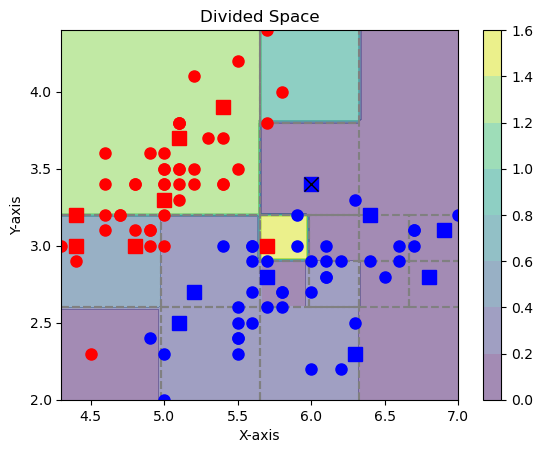

18
16
27
There is a problem with FindNoUnlabeledPtsinCell Du


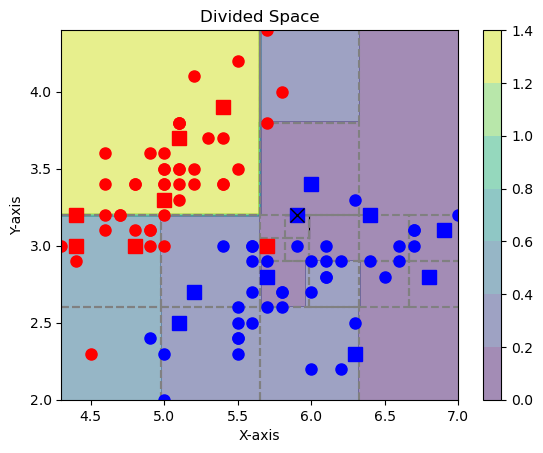

20
17
55
There is a problem with FindNoUnlabeledPtsinCell Du


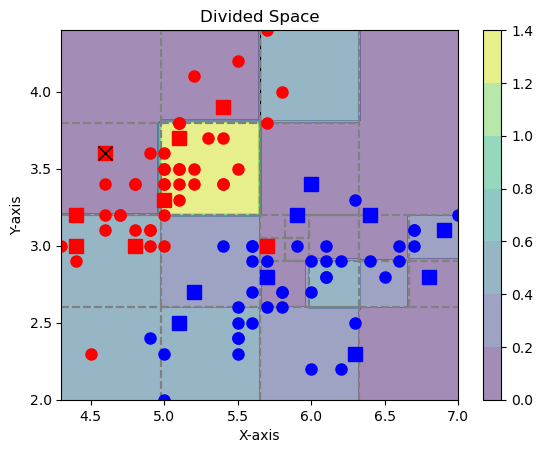

23
18
107
There is a problem with FindNoUnlabeledPtsinCell Du


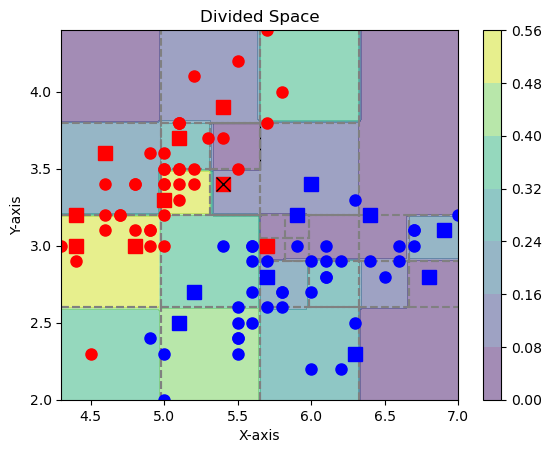

25
19
214
There is a problem with FindNoUnlabeledPtsinCell Du


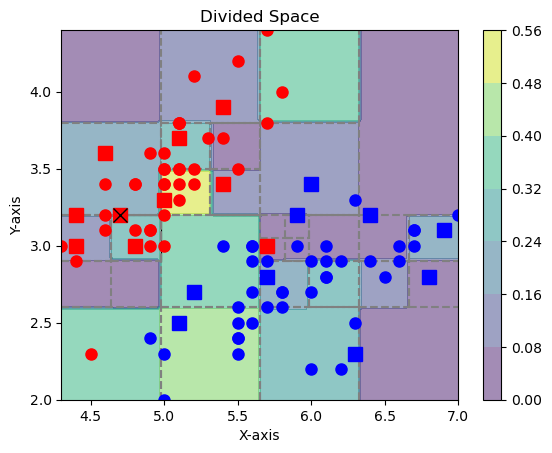

27
20


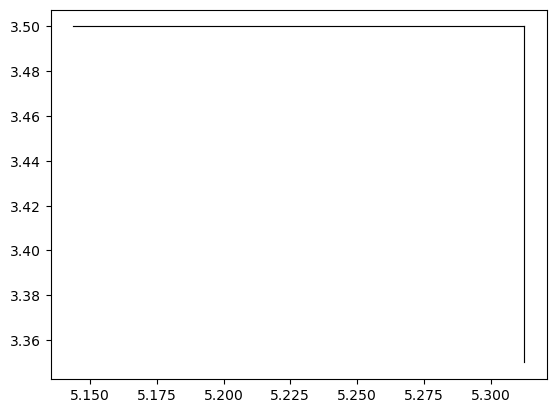

In [28]:
for iter in range(0,5):
    NewAnnotatedPoint,NewAnnotatedPoint_idx,NewModel, quad_uncertainties=select_instances(FinalModel, X_labeled, y_labeled, X_pool, Lb, Ub, Nc, Quad)           
    draw_divisions(Quad, dim, X_labeled, y_labeled, X_pool, y_pool, quad_uncertainties)

    if len(NewModel)>0:
        FinalModel=FinalModel+NewModel
    X_labeled = np.r_[X_labeled, NewAnnotatedPoint.reshape(1,-1)]
    y_labeled= np.r_[y_labeled, y_pool[61]]
    X_pool = np.delete(X_pool, NewAnnotatedPoint_idx, axis=0)
    y_pool = np.delete(y_pool, NewAnnotatedPoint_idx, axis=0)

    # This code should be run after each annotation
    FoundIn,XX =search_for_labeled_points(dim, Quad, Lb, Ub, X_labeled)
    NewLb = [Quad[i]['Lb'] for i in FoundIn]
    NewUb = [Quad[i]['Ub'] for i in FoundIn]
    FoundIn_int = int(FoundIn[0])
    NewQuad,XX=divide_space(NDivisions,dim, NewLb, NewUb, PlotFlag=1)
    TempTempQuad=Quad
    del Quad[FoundIn_int]
    for ii in range(len(NewQuad)):
        Quad.append(NewQuad[ii])
    _, SumPts = SearchforLabeledpoints2(dim, Quad, Lb,  np.r_[X_labeled, X_pool])
    #if sum(SumPts) != np.r_[X_labeled, X_pool].shape[0]:
        #print('Problem in Dimensions')

    IIIDDDx = SumPts == 0
    Quad = [quad for quad, i in zip(Quad, IIIDDDx) if not i]
